In [1]:
from tweepy import API, Cursor, OAuthHandler, Stream
from tweepy.streaming import StreamListener
import creds
import json

class TwitterClient():
    def __init__(self, twitter_user=None):
        self.auth = TwitterAuthenicator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)
        self.twitter_user = twitter_user
    
    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets
    
    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_woeid_of_trending_tweets(self):
        with open('woeid_trends.json', 'a') as tf:
            json.dump(self.twitter_client.trends_available(), tf)
    


class TwitterAuthenicator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(creds.CONSUMER_API_KEY, creds.CONSUMER_SECRET)
        auth.set_access_token(creds.ACCESS_TOKEN, creds.ACCESS_TOKEN_SECRET)
        return auth

class TwitterStreamer():
    def __init__(self):
        self.twiiter_authenicator = TwitterAuthenicator()

    def stream_tweets(self, fname, hashtag_list):
        listener = StdOutListener(fname)
        auth = self.twiiter_authenicator.authenticate_twitter_app()
        stream = Stream(auth, listener)
        stream.filter(track=hashtag_list)
        
class StdOutListener(StreamListener):

    def __init__(self, fname):
        self.fname = fname

    def on_data(self, data):
        try:

            print(data)
            with open(fname, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("error on data %s", str(e))

        return True

    def on_error(self, status):
        if status == 420:
            # Return false if we reach rate limit
            return False
        print(status)

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from textblob import TextBlob
import re


class TweetAnalyzer():
    
    def clean_tweet(self, tweet):
        # remove speical characters and hyperlinks
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1
    
    def tweets_to_df(self,tweets):
        df = pd.DataFrame(data=[tweet.full_text for tweet in tweets], columns=['tweets'])
        df['id'] = np.array([tweet.id for tweet in tweets])
        df['date_created'] = np.array([tweet.created_at for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweet_count'] = np.array([tweet.retweet_count for tweet in tweets])
        df['len'] = np.array([len(tweet.full_text) for tweet in tweets])
        df['sentiment'] = np.array([self.analyze_sentiment(tweet) for tweet in df['tweets']])
        df['date_created'] = pd.to_datetime(df['date_created'])
        df['tweet_date'] = [d.date() for d in df['date_created']]
        df['tweet_day_of_week'] = df['date_created'].dt.weekday_name
        df['tweet_hour'] = df['date_created'].dt.hour
        
        return df
    
    def analyse_tweets(self, tweets):

        df = self.tweets_to_df(tweets)
        df['av_len_tweet'] = np.mean(df['len'])
        df['av_tweets_per_day'] = df.groupby('tweet_date')['tweets'].count().mean() 
        df['av_sentiment'] = np.mean(df['sentiment'])
        
        max_idx = df.groupby(['tweets'])['likes'].transform(max) == df['likes'].max()
        df['most_liked_tweet']= df[max_idx]['tweets'][:1]
        
        min_idx = df.groupby(['tweets'])['likes'].transform(max) == df['likes'].min()
        df['least_liked_tweet'] = df[min_idx]['tweets'][:1]
        
        most_retweets_idx = df.groupby(['tweets'])['retweet_count'].transform(max) == df['retweet_count'].max()
        df['most_retweeted_tweet'] = df[most_retweets_idx]['tweets'][:1]
        
        #self.write_to_json(tweets, df)
        return df
        
        
    def write_to_json(self, tweets, df):
        fname = tweets[0].user.screen_name + "-" + str(df['date_created'].dt.date.min()) + "-" + str(df['date_created'].dt.date.max())
        try: 
            df.to_json(fname, orient='table')
            print('wrote file to ', fname)
        except e:
            print('error writing to json', e)

In [157]:
twitter_client = TwitterClient()
api = twitter_client.get_twitter_client_api()
ta = TweetAnalyzer()

In [158]:
tweets = api.user_timeline(screen_name='realDonaldTrump', count=200, tweet_mode="extended")
df = ta.analyse_tweets(tweets)
ta.write_to_json(tweets, df)

wrote file to  realDonaldTrump-2019-07-24-2019-08-04


In [159]:
tweets_ndt = api.user_timeline(screen_name='neiltyson', count=200, tweet_mode="extended")
df = ta.analyse_tweets(tweets_ndt)
ta.write_to_json(tweets_ndt, df)

wrote file to  neiltyson-2019-02-23-2019-08-04


In [160]:
tweets_rg = api.user_timeline(screen_name='rickygervais', count=200, tweet_mode="extended")
df = ta.analyse_tweets(tweets_rg)
ta.write_to_json(tweets_rg, df)

wrote file to  rickygervais-2019-07-23-2019-08-04


In [161]:
tweets_em = api.user_timeline(screen_name='elonmusk', count=200, tweet_mode="extended")
df = ta.analyse_tweets(tweets_em)
ta.write_to_json(tweets_em, df)

wrote file to  elonmusk-2019-07-17-2019-08-04


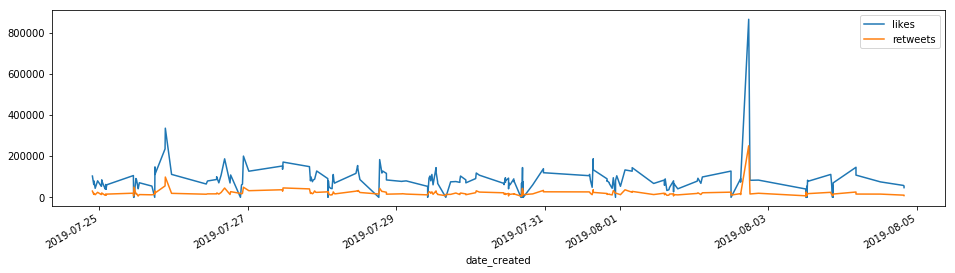

In [85]:
time_likes = pd.Series(data=df['likes'].values, index=df['date_created'])
time_likes.plot(figsize=(16,4), label='likes', legend=True)
time_retweets = pd.Series(data=df['retweet_count'].values, index=df['date_created'])
time_retweets.plot(figsize=(16,4), label='retweets', legend=True)
plt.show()

## Apply Spacy and Gensim to Tweets for higher data analysis

## get trending hashtags by country
    * US: 23424977
    * UK: 23424975
    * Aus: 23424748
    * Canada: 23424775
    * NZ: 23424916